In [2]:
pip install fiona rasterio scikit-image matplotlib opencv-python pandas numpy scikit-image

     --------------------------------------- 24.5/24.5 MB 14.2 MB/s eta 0:00:00
     --------------------------------------- 25.4/25.4 MB 19.3 MB/s eta 0:00:00
     --------------------------------------- 12.9/12.9 MB 23.4 MB/s eta 0:00:00
     --------------------------------------- 39.5/39.5 MB 23.4 MB/s eta 0:00:00
     ---------------------------------------- 227.3/227.3 kB ? eta 0:00:00
     ------------------------------------- 315.8/315.8 kB 20.4 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 26.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


C:\Users\nhj4\anaconda3\lib\site-packages\rasterio\__init__.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


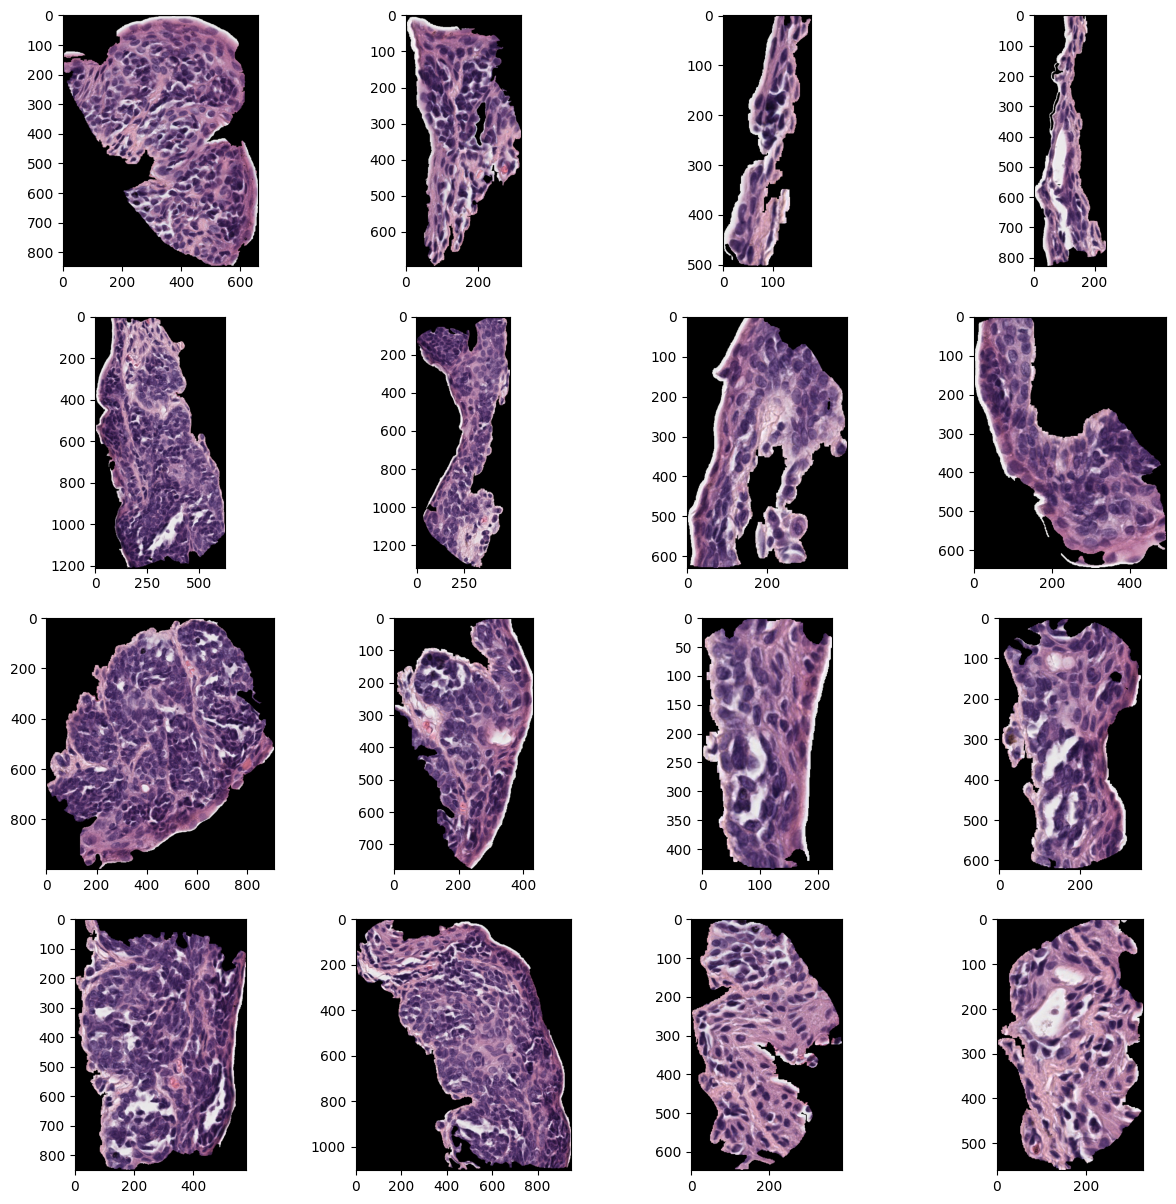

In [7]:
import fiona
import cv2
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import morphology

with fiona.open("cell_geo_small.geojson", "r") as geojson:
   features = [feature["geometry"] for feature in geojson]

fig, axs = plt.subplots(4, 4, figsize=(15, 15))
axs=axs.flatten()

with rasterio.open("h2114153  h&e_ROI_1 Epithelia.png") as src:
    for i,feature in enumerate(features):
            out_image,_=rasterio.mask.mask(src,[feature],crop=True)
            axs[i].imshow(out_image.transpose((1,2,0)))

In [143]:
image = cv2.imread('h2114153  h&e_ROI_1 Epithelia.png', cv2.IMREAD_COLOR)
new_image = np.array(image) == 0
new = np.array(image) > 0
skeleton = morphology.skeletonize(np.any((image > 0).astype('float'), axis = -1))

In [154]:
from scipy.ndimage import binary_dilation
skeleton_2d_thicker = binary_dilation(skeleton, structure=np.ones((10, 10)))


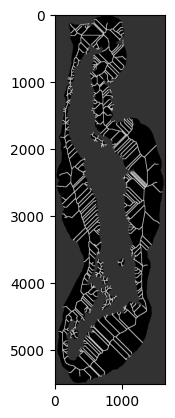

In [159]:
plt.imshow(skeleton_2d_thicker, cmap = 'gray', alpha = 1)
plt.imshow(new_image[:,:,1], cmap = 'gray', alpha = 0.2)

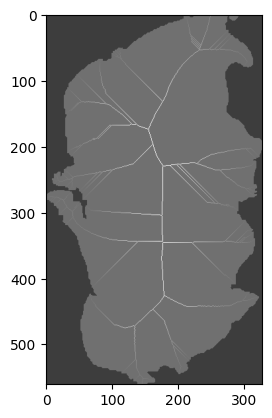

In [134]:
# Testing skeletonize from morphology
skel, distance = morphology.medial_axis(out_image.transpose(1, 2, 0)[:,:,0], return_distance=True)
dist_on_skel = distance * skel
plt.imshow(dist_on_skel, alpha = 0.7, cmap= plt.cm.gray)
plt.imshow(out_image.transpose(1, 2, 0)[:,:,0] > 0, alpha = 0.2, cmap = 'gray')

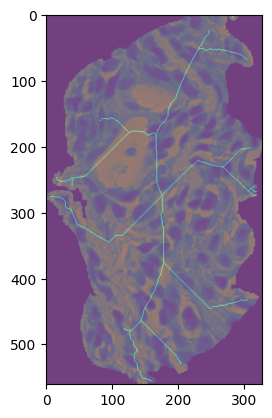

In [11]:
# Different method for skeletonize
plt.imshow(out_image.transpose(1, 2, 0)[:,:,0], alpha = 0.5)
plt.imshow(morphology.skeletonize(out_image.transpose(1, 2, 0)[:,:,0], method = 'lee'), alpha = 0.5)

In [12]:
# This function will take in one of the features created above and generate a patch.
# I think having a rudimentary solution based on (brute force) would be better than trying to think up a way to create a patch from some obscure package we would
# have to research, etc. We should maybe ask the thinkers to figure out a way to smartly generate patches either using a package or some algorithm, as of right now, though
# creating some base solution would be better, I feel.
def initial_patches(feature):
    # Have patches be scaled to 1/16 of total feature by length of feature
    coordinates = np.array([x for xs in feature.coordinates for x in xs])
    x_min = coordinates[:,0].min()
    x_max = coordinates[:,0].max()
    y_min = coordinates[:,1].min()
    y_max = coordinates[:,1].max()
    patch_length = min(y_max - y_min, x_max - x_min) / 16

    # Start two patch lengths away from x_min coordinate y_max coordinate and create array
    # Array will contain the coordinates of top left part of square
    x = np.arange(x_min - 2*patch_length, x_max + 2*patch_length, patch_length)
    y = np.arange(y_max + 2*patch_length, y_min - 2*patch_length, -patch_length)

    x_grid, y_grid = np.meshgrid(x, y)
    patches = np.concatenate((x_grid.reshape(-1, 1), y_grid.reshape(-1, 1)), axis = 1)

    return patches

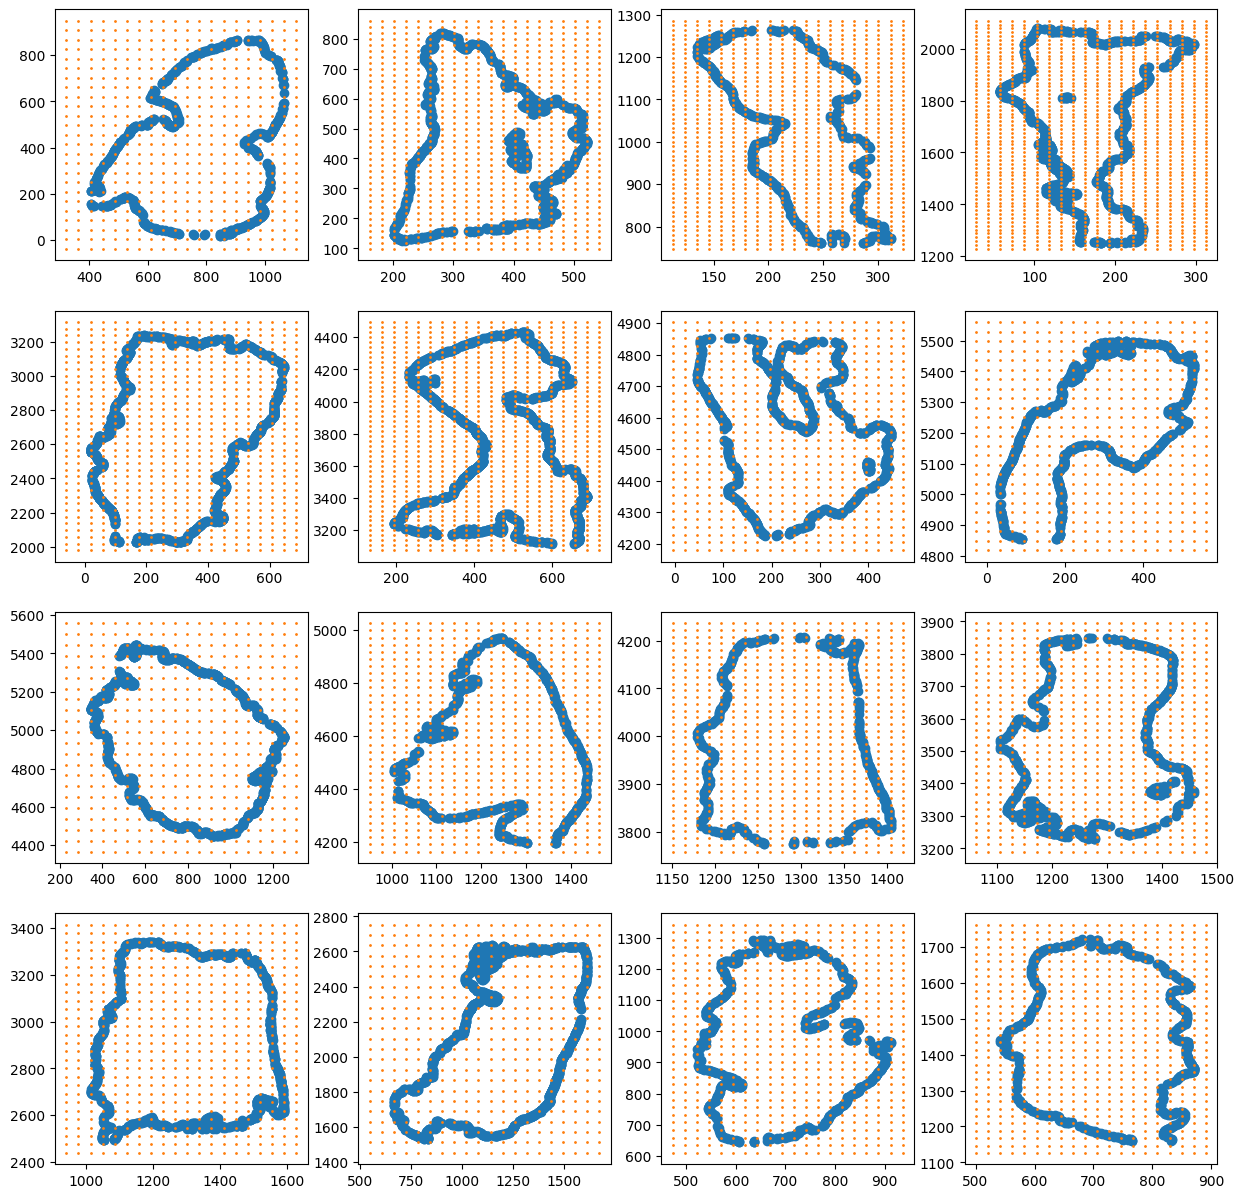

In [13]:
# Demonstration of code, needs some configuring if want to overlay dots on actual image
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
axs=axs.flatten()

for i, feature in enumerate(features):
  coordinates = np.array([x for xs in feature.coordinates for x in xs]).reshape(-1, 2)
  axs[i].scatter(coordinates[:,0], coordinates[:,1])
  axs[i].scatter(initial_patches(feature)[:,0], initial_patches(feature)[:,1], s = 1)

In [ ]:
# Choosing square logic
def choose_square(feature, patch_coords):
    #